<a href="https://colab.research.google.com/github/islam-mirajul/Fake-Hilsa-Fish-Detection-Using-CNN/blob/main/Fake-Hilsa-Detection(DenseNet201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
print("TF Version:", tf.__version__)

TF Version: 2.2.0


In [ ]:
import tensorflow_hub as hub
print("TF hub Version:", hub.__version__)

TF hub Version: 0.8.0


In [ ]:
print("GPU", "availabe" if tf.config.list_physical_devices("GPU") else "not availabe")

GPU availabe


In [ ]:

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9519771956713794041, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5810135846681122437
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7407528689303415146
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14711541891715275415
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [ ]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop

from keras.models import Model

from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.applications.inception_v3 import DenseNet201

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [ ]:
import keras
keras.__version__

'2.3.1'

In [ ]:
output_classes = 2
batch_size = 16
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 5
nb_train_samples =2500
nb_test_samples =500

In [ ]:

train_dir = '/content/drive/My Drive/Project-data-shape-2/train'
test_dir = '/content/drive/My Drive/Project-data-shape-2/test'

In [ ]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))


print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

/content/drive/My Drive/Project-data-shape-2/train 0
/content/drive/My Drive/Project-data-shape-2/train/Hilsa-Fish 6981
/content/drive/My Drive/Project-data-shape-2/train/Fake-Hilsa-Fish 6320
******************************
/content/drive/My Drive/Project-data-shape-2/test 0
/content/drive/My Drive/Project-data-shape-2/test/Hilsa-Fish 1741
/content/drive/My Drive/Project-data-shape-2/test/Fake-Hilsa-Fish 1580


In [ ]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='binary')


test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='binary')

Found 13301 images belonging to 2 classes.
Found 3321 images belonging to 2 classes.


In [ ]:
from keras.applications import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation=tf.nn.sigmoid)(x)

model = Model(inputs=base_model.input,outputs=prediction)

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)
eve_opt = Eve(lr=1e-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

model.compile(optimizer= adam_opt,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/5
156/156 [==============================] - 1124s 7s/step - loss: 1.0085 - accuracy: 0.6206 - val_loss: 0.4968 - val_accuracy: 0.8629
Epoch 2/5
156/156 [==============================] - 1082s 7s/step - loss: 0.7315 - accuracy: 0.7728 - val_loss: 0.6043 - val_accuracy: 0.9496
Epoch 3/5
156/156 [==============================] - 1105s 7s/step - loss: 0.6178 - accuracy: 0.8277 - val_loss: 0.2870 - val_accuracy: 0.9718
Epoch 4/5
156/156 [==============================] - 1082s 7s/step - loss: 0.5280 - accuracy: 0.8716 - val_loss: 0.2528 - val_accuracy: 0.9496
Epoch 5/5
156/156 [==============================] - 1109s 7s/step - loss: 0.4616 - accuracy: 0.8962 - val_loss: 0.2636 - val_accuracy: 0.9536


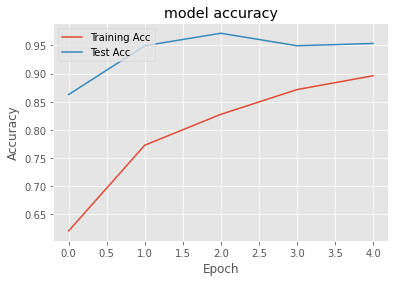

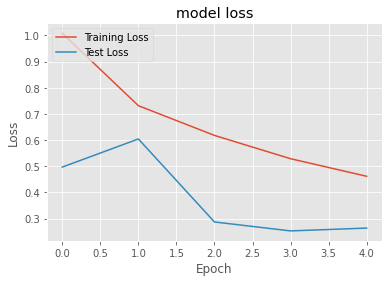

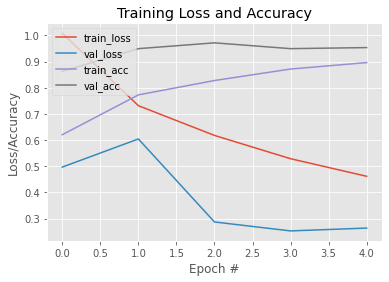

In [ ]:
plt.style.use("ggplot")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [ ]:
score = model.evaluate_generator(test_generator, steps=5)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.25406742095947266
Validation Accuracy:  1.0


In [ ]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

208/207 [==============================] - 404s 2s/step
No of errors = 99/3321


Confusion Matrix
[[1563   17]
 [  82 1659]]


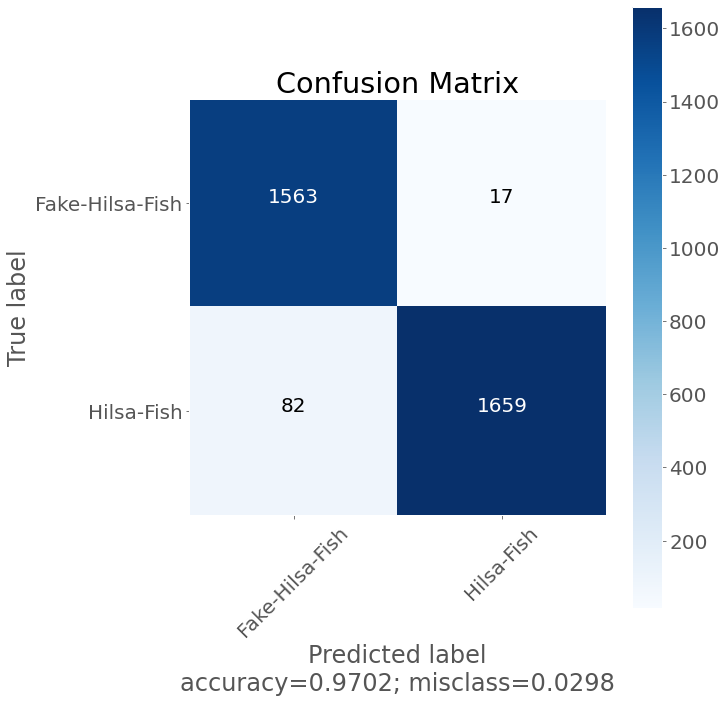

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    ##plt.savefig('plots/12.DenseNet-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[1563   17]
 [  82 1659]]
                 precision    recall  f1-score   support

Fake-Hilsa-Fish       0.95      0.99      0.97      1580
     Hilsa-Fish       0.99      0.95      0.97      1741

       accuracy                           0.97      3321
      macro avg       0.97      0.97      0.97      3321
   weighted avg       0.97      0.97      0.97      3321



In [ ]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.9701897018970189
Sensitivity :  0.9501519756838905
Specificity :  0.9898568019093079


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc))
print('Precision: {:.4f}'.format(prec))
print('Recall:    {:.4f}'.format(recall))
print('F1:        {:.4f}'.format(f1))

Accuracy:  0.9702
Precision: 0.9899
Recall:    0.9529
F1:        0.9710


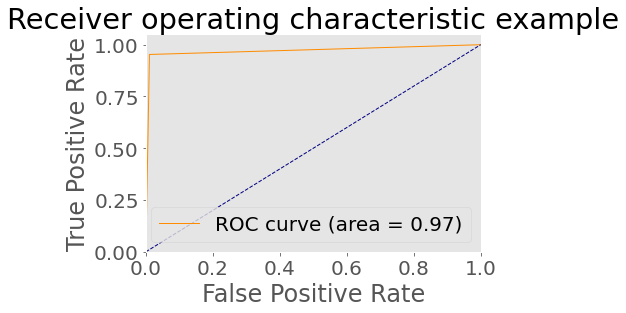

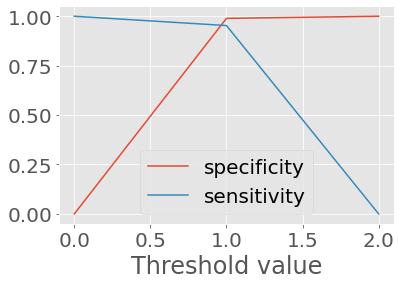

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 16})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/model/12.DenseNet201(half_data)-hilsa-DataSet-Model.h5')
model.save_weights('/content/drive/My Drive/model/12.DenseNet201(half-data)-hilsa-Weights.h5')